# Iteration test
This file demonstrates how to initialize an Equilibrium object from leading order quantities and tests its accuracy.

In [1]:
# This file implements and tests recursion relations
import numpy as np
import timeit
import scipy.signal
from matplotlib import pyplot as plt
from numba import jit, njit, prange
from numba import complex128, int64    # import jit value types

# for importing parsed codes
import sys
import cProfile
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/MHD_parsed/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from recursion_relations import *


import MHD_parsed
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

Detected 16 CPU's. Setting n_jobs to #CPU/2.


Axis shape:


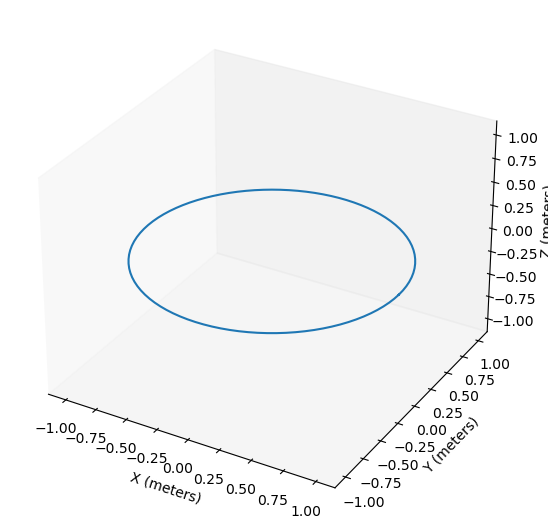

In [2]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )

## Initializing an `Equilibrium`
### Required quantities and orders
Unknowns:

1. X_coef_cp: 2
2. Y_coef_cp: 2
3. Z_coef_cp: 2
4. B_psi_coef_cp: 0
5. B_theta_coef_cp: 2
6. iota_coef: 0
7. Delta_coef_cp: 3
8. p_perp_coef_cp: 3

Known constants:
1. B_denom_coef_c: 2
2. B_alpha_coef: 1
3. kap_p
4. dl_p 
5. tau_p
6. eta

In [3]:
equilibrium = Equilibrium.from_known(
    X_coef_cp=X_coef_cp.mask(2),
    Y_coef_cp=Y_coef_cp.mask(2),
    Z_coef_cp=Z_coef_cp.mask(2),
    B_psi_coef_cp=B_psi_coef_cp.mask(0),
    B_theta_coef_cp=B_theta_coef_cp.mask(2),
    B_denom_coef_c=B_denom_coef_c.mask(2),
    B_alpha_coef=B_alpha_coef.mask(1),
    iota_coef=iota_coef.mask(0), 
    kap_p=kap_p, 
    dl_p=dl_p, 
    tau_p=tau_p,
    eta=eta,
    p_perp_coef_cp = p_perp_coef_cp.mask(2), 
    Delta_coef_cp = Delta_coef_cp.mask(2))
equilibrium.get_order()

integral_mode is fft


2

## Accuracy with different maximum frequency considered in ODE solve

In [9]:
max_freq_list = [2,3,4,5,10,15,20,25,30,40,50,100]
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
for i in max_freq_list:
    equilibrium.iterate_2(
        n_eval=4,
        B_alpha_nb2=0,
        B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
        iota_new=iota_coef[1],
        loop_max_freq=(i,500)
    )
    n=4
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']

    J = MHD_parsed.validate_J(n,
        X_coef_cp,
        Y_coef_cp, 
        Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        kap_p, dl_p, tau_p, iota_coef)
    J_list.append(np.average(np.abs(J.content)))
    Cb = MHD_parsed.validate_Cb(n-1,
        X_coef_cp,
        Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck = MHD_parsed.validate_Ck(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct = MHD_parsed.validate_Ct(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ct_list.append(np.average(np.abs(Ct.content)))
    I = MHD_parsed.validate_I(n, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    I_list.append(np.average(np.abs(I.content)))
    # II 4 not satisfied.
    II = MHD_parsed.validate_II(n,
        B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp, iota_coef)
    II_list.append(np.average(np.abs(II.content)))
    III = MHD_parsed.validate_III(n-2,
        B_theta_coef_cp, B_psi_coef_cp,
        B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    III_list.append(np.average(np.abs(III.content)))


Evaluating order 3 4
iota 1 -0.66367278
solve_integration_factor: average p_eff: 1.05129704
solve_integration_factor: average f_eff: 0.12055464001415185
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
solve_integration_factor: average p_eff: 1.2615564479999999
solve_integration_factor: average f_eff: 0.3221525232858807
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 30.865209817886353
Evaluating order 3 4
iota 1 -0.66367278
solve_integration_factor: average p_eff: 1.05129704
solve_integration_factor: average f_eff: 0.12055494920649584
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
solve_integration_factor: average p_eff: 1.2615564479999999
solve_integration_factor: average f_eff: 0.321837306399288
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 31.760576009750366
Evaluating order 3 4
iota 1 -0.66367278
solve_integ

In [16]:

plt.plot(max_freq_list, J_list)
plt.ylabel('J_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, Cb_list)
plt.ylabel('Cb_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, Ck_list)
plt.ylabel('Ck_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, Ct_list)
plt.ylabel('Ct_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, I_list)
plt.ylabel('I_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, II_list)
plt.ylabel('II_list')
plt.xlabel('loop_max_freq')
plt.show()
plt.plot(max_freq_list, III_list)
plt.ylabel('III_list')
plt.xlabel('loop_max_freq')
plt.show()

NameError: name 'max_freq_list' is not defined

In [22]:
list(range(1,5+1))

[1, 2, 3, 4, 5]

## Accuracy with different off-diagonal components left in before inversion

### Low pass filter not applied

In [12]:
max_k_diff_pre_inv_list = [2,3,4,5,10,15,20,25,30,40,50,100]
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
for i in max_k_diff_pre_inv_list:
    equilibrium.iterate_2(
        n_eval=4,
        B_alpha_nb2=0,
        B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
        iota_new=iota_coef[1],
        loop_max_freq=(500,500),
        max_k_diff_pre_inv=(i,1000)
    )
    n=4
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']

    J = MHD_parsed.validate_J(n,
        X_coef_cp,
        Y_coef_cp, 
        Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        kap_p, dl_p, tau_p, iota_coef)
    J_list.append(np.average(np.abs(J.content)))
    Cb = MHD_parsed.validate_Cb(n-1,
        X_coef_cp,
        Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck = MHD_parsed.validate_Ck(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct = MHD_parsed.validate_Ct(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ct_list.append(np.average(np.abs(Ct.content)))
    I = MHD_parsed.validate_I(n, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    I_list.append(np.average(np.abs(I.content)))
    # II 4 not satisfied.
    II = MHD_parsed.validate_II(n,
        B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp, iota_coef)
    II_list.append(np.average(np.abs(II.content)))
    III = MHD_parsed.validate_III(n-2,
        B_theta_coef_cp, B_psi_coef_cp,
        B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    III_list.append(np.average(np.abs(III.content)))


Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 65.47149109840393
Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 62.31581687927246
Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 60.13214182853699
Evaluating order 3 4
integral_mode is fft
(4, 4, 100

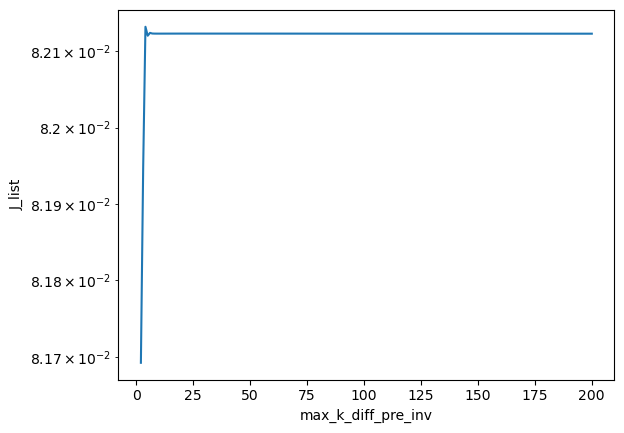

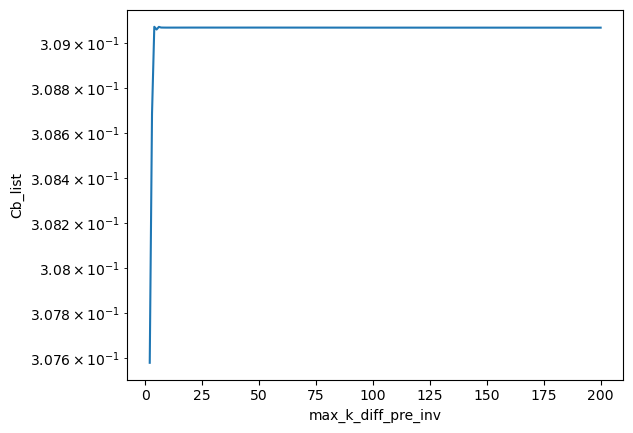

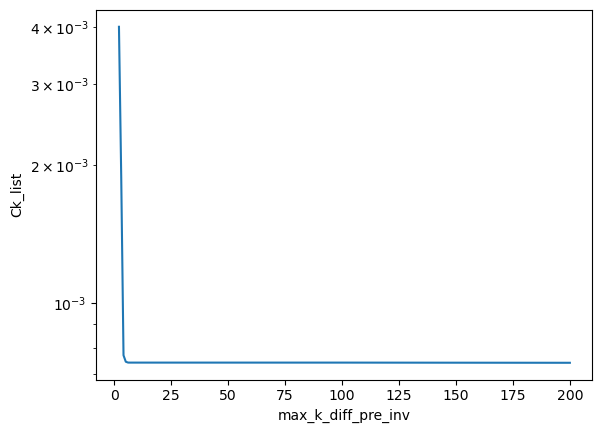

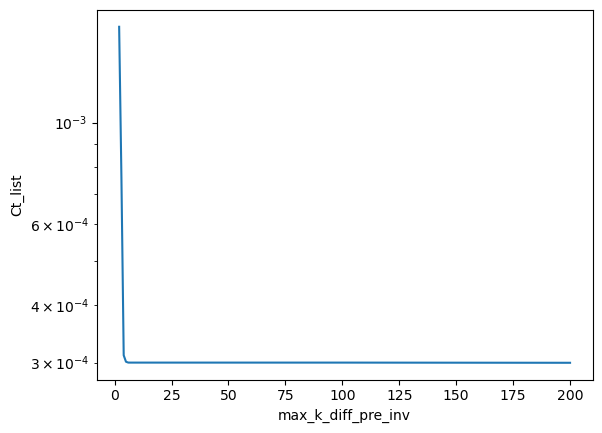

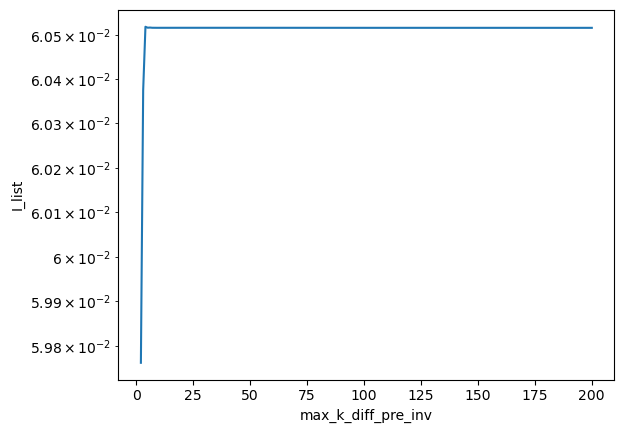

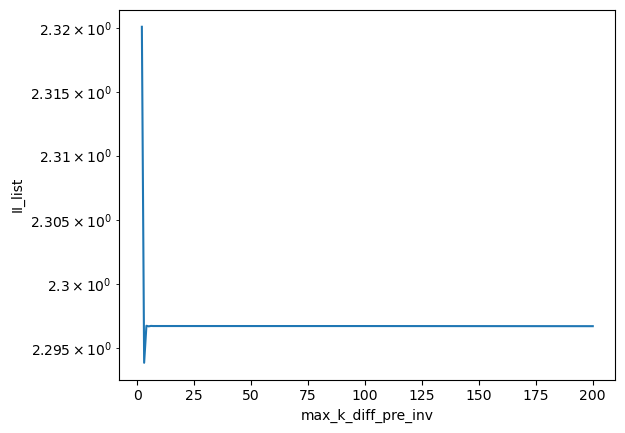

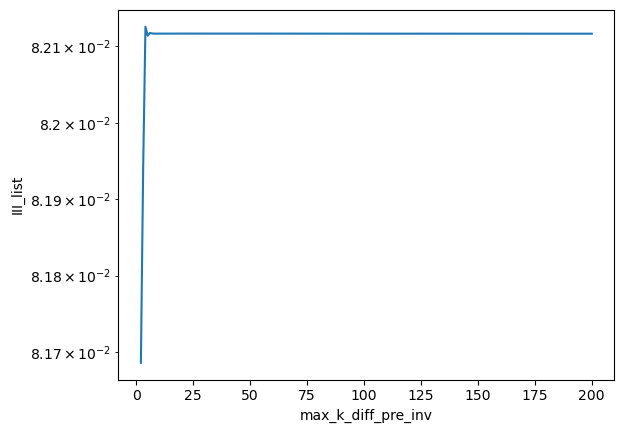

In [15]:

plt.plot(max_k_diff_pre_inv_list, J_list)
plt.yscale('log')
plt.ylabel('J_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Cb_list)
plt.yscale('log')
plt.ylabel('Cb_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ck_list)
plt.yscale('log')
plt.ylabel('Ck_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ct_list)
plt.yscale('log')
plt.ylabel('Ct_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, I_list)
plt.yscale('log')
plt.ylabel('I_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, II_list)
plt.yscale('log')
plt.ylabel('II_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, III_list)
plt.yscale('log')
plt.ylabel('III_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()

### Low pass filter applied

In [7]:
# With filtering already applied
max_k_diff_pre_inv_list = [2,3,4,5,10,15,20,25,30,40,50,100]
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
for i in max_k_diff_pre_inv_list:
    equilibrium.iterate_2(
        n_eval=4,
        B_alpha_nb2=0,
        B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
        iota_new=iota_coef[1],
        loop_max_freq=(20,500),
        max_k_diff_pre_inv=(i,1000)
    )
    n=4
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']

    J = MHD_parsed.validate_J(n,
        X_coef_cp,
        Y_coef_cp, 
        Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        kap_p, dl_p, tau_p, iota_coef)
    J_list.append(np.average(np.abs(J.content)))
    Cb = MHD_parsed.validate_Cb(n-1,
        X_coef_cp,
        Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck = MHD_parsed.validate_Ck(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct = MHD_parsed.validate_Ct(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ct_list.append(np.average(np.abs(Ct.content)))
    I = MHD_parsed.validate_I(n, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    I_list.append(np.average(np.abs(I.content)))
    # II 4 not satisfied.
    II = MHD_parsed.validate_II(n,
        B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp, iota_coef)
    II_list.append(np.average(np.abs(II.content)))
    III = MHD_parsed.validate_III(n-2,
        B_theta_coef_cp, B_psi_coef_cp,
        B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    III_list.append(np.average(np.abs(III.content)))


Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 32.94901418685913
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 27.98995089530945
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 31.828193187713623
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_dif

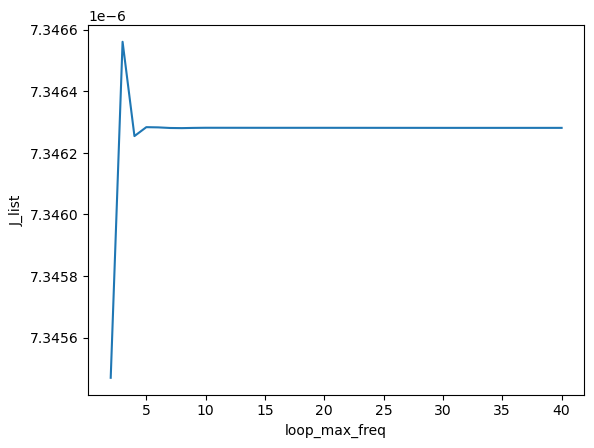

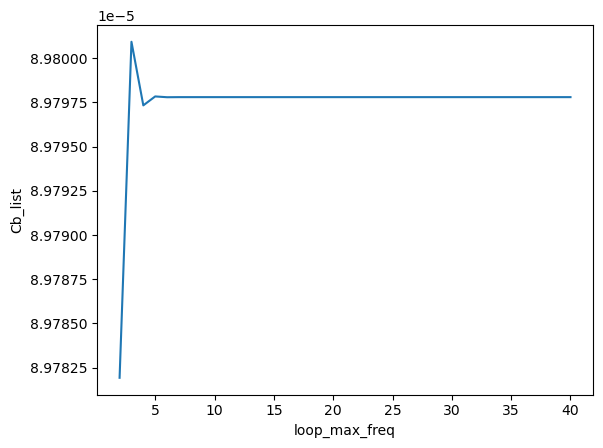

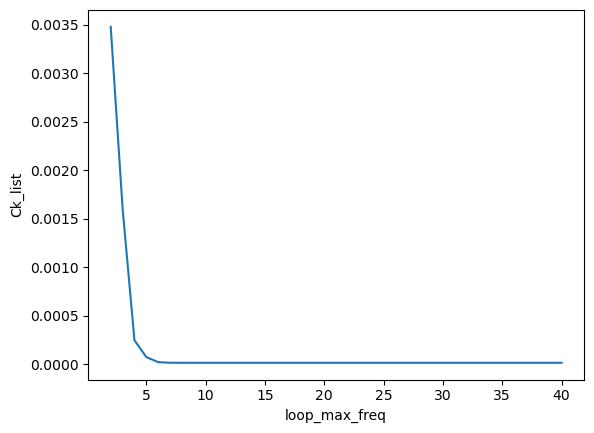

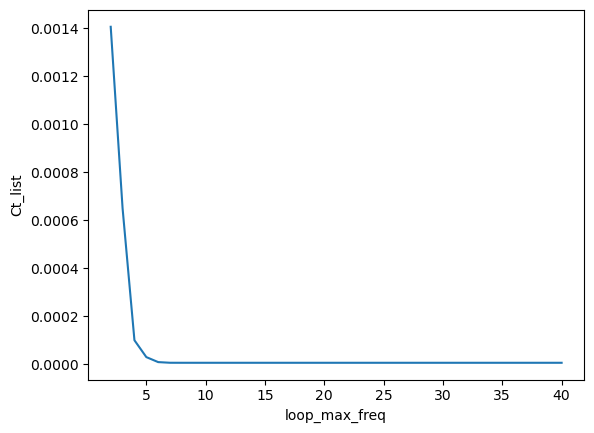

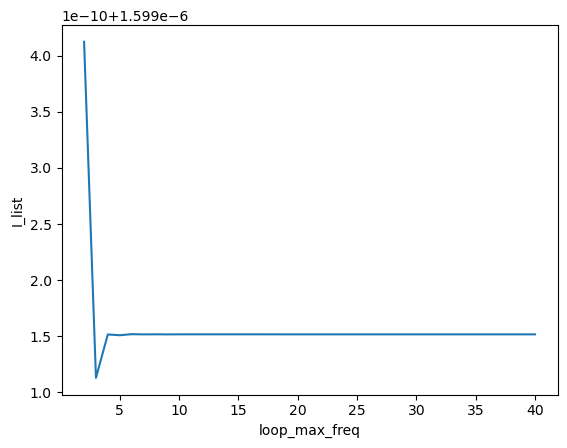

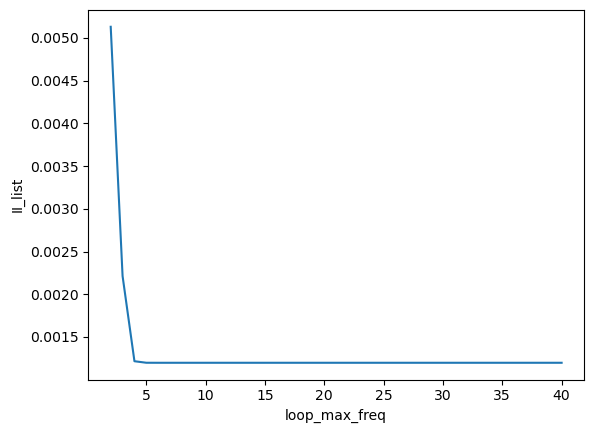

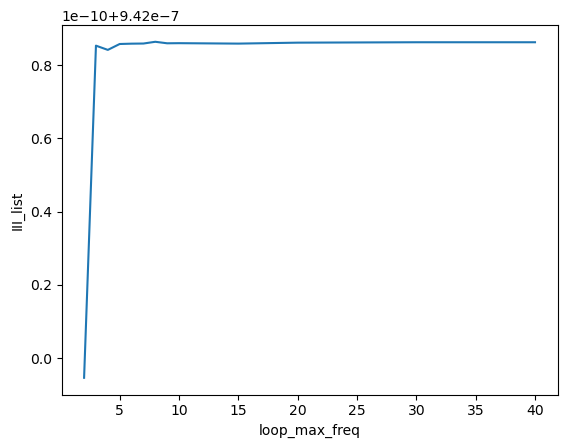

In [8]:

plt.plot(max_k_diff_pre_inv_list, J_list)
plt.ylabel('J_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Cb_list)
plt.ylabel('Cb_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ck_list)
plt.ylabel('Ck_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ct_list)
plt.ylabel('Ct_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, I_list)
plt.ylabel('I_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, II_list)
plt.ylabel('II_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, III_list)
plt.ylabel('III_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()

In [17]:
a = [1,2,3,4,5,6,7,8]

In [18]:
a[:2]

[1, 2]